In [7]:
# 1. Environment & Imports (with path setup)
import os, time, json, sys
from pathlib import Path

# Determine project root (parent of notebooks directory)
ROOT = Path.cwd().parent  # notebooks -> upreg_classify
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))  # ensure 'src' package import works

# Diagnostic: interpreter path
print('sys.executable:', sys.executable)
# Optional: verify path injection
print('Added to sys.path:', str(ROOT) in sys.path)
print('sys.path[0]:', sys.path[0])

from autogluon.tabular import TabularPredictor
# Import project training entry
from src.train.train import train_and_evaluate

DATA_RAW = ROOT / 'data' / 'raw'
MODELS_DIR = ROOT / 'models'
print('ROOT:', ROOT)
print('Data raw exists:', DATA_RAW.exists())
print('Models dir:', MODELS_DIR)

sys.executable: c:\PythonProjects\rl_reserve_markets\.venv1\Scripts\python.exe
Added to sys.path: True
sys.path[0]: C:\Users\haako\AppData\Local\Programs\Python\Python312\python312.zip
ROOT: c:\PythonProjects\rl_reserve_markets\upreg_classify
Data raw exists: True
Models dir: c:\PythonProjects\rl_reserve_markets\upreg_classify\models


In [8]:
# 2. Utility wrapper
import importlib

def reload_all():
    """Reload key project modules to pick up file changes without restarting VS Code."""
    print('--- Reloading project modules ---')
    import src.data.preprocess as dp
    import src.data.features as feat
    import src.train.hyperparameters as hp
    import src.train.train as tr
    importlib.reload(dp)
    importlib.reload(feat)
    importlib.reload(hp)
    importlib.reload(tr)
    # Re-export key symbols to current namespace if needed
    from src.train.train import train_and_evaluate as _tae
    globals()['train_and_evaluate'] = _tae
    print('Reloaded: preprocess, features, hyperparameters, train')


def run_training(description: str, **kwargs):
    """Run training via train_and_evaluate and report duration + key metrics.
    Required kwargs mirror train_and_evaluate parameters.
    """
    print(f'=== Run: {description} ===')
    start = time.time()
    metrics = train_and_evaluate(**kwargs)
    dur = time.time() - start
    print(f'Completed in {dur:.1f}s')
    print(json.dumps(metrics, indent=2))
    return metrics


def base_common(area='NO1'):
    return dict(
        task='multiclass',
        area=area,
        data_dir=str(DATA_RAW),
        include_2024=True,
        heavy_interactions=False,
        dropna=True,
        train_frac=0.6, val_frac=0.2, test_frac=0.2,
        activation_lag_start=4,
        single_persistence=True,
        weight_factor_up=1.0, weight_factor_down=1.0, weight_factor_none=1.0,
        tune_up_bias=True, tune_up_objective='macro',
        num_bag_folds=0, num_stack_levels=0,
        importance_time_limit=60, importance_subsample=1200, importance_top_n=40,
        use_categorical_reglag=False,
        data_start=None,
    )

In [ ]:
# 3. Quick RF/XT priority baseline (NO1)
baseline_cfg = base_common(area='NO1')
baseline_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'baseline_rf_xt_priority'),
    time_limit=120,
    presets='best_quality',
    model_preset='rf_xt_priority',
    hpo_trials=0, hpo_searcher='random', hpo_scheduler='local',
))
# Uncomment to run
# run_training('Baseline RF/XT Priority NO1', **baseline_cfg)

=== Run: CatBoost-only HPO(4) NO1 ===
Flow index range: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
[add_interactions] Dropping duplicate columns to avoid reindex errors: ['NO1-NO2_ratio', 'NO1-NO3_ratio', 'NO1-NO5_ratio', 'NO1-SE3_ratio']


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       4.42 GB / 13.85 GB (31.9%)
Disk Space Avail:   403.08 GB / 952.62 GB (42.3%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1


Consumption shape: (65568, 1)
Production shape: (65568, 8)
Day-ahead prices shape: (65760, 2)
Intraday hourly stats shape: (65565, 13)
Number of NaNs before dropna: 15803
Normalized nullable integer dtypes to int64 for: ['DA Scarcity', 'aFRR_ActDirNum-4', 'aFRR_ActDirNum-6', 'aFRR_ActDirNum-8', 'aFRR Activation x mFRR Activation -4', 'aFRR Activation x mFRR Activation -6']
Final preprocessed DataFrame shape: (63341, 91)
                     NO1-NO2_ratio  NO1-NO3_ratio  NO1-NO5_ratio  \
Time                                                               
2025-11-08 20:45:00       0.535190       0.570551       0.463167   
2025-11-08 21:00:00       0.569671       0.610564       0.448474   

                     NO1-SE3_ratio  RegLag-4 RegLagCat-4  RegLag-6  \
Time                                                                 
2025-11-08 20:45:00       0.174695        -1        down        -1   
2025-11-08 21:00:00       0.207251        -1        down        -1   

                    Re

Beginning AutoGluon training ... Time limit = 240s
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\cat_only_hpo4_no_bag"
Train Data Rows:    38004
Train Data Columns: 90
Tuning Data Rows:    12668
Tuning Data Columns: 90
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4481.14 MB
	Train Data (Original)  Memory Usage: 31.41 MB (0.7% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting Cat

  0%|          | 0/4 [00:00<?, ?it/s]

Fitted model: CatBoost\T1 ...
	0.6152	 = Validation score   (f1_macro)
	14.43s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: CatBoost\T2 ...
	0.6232	 = Validation score   (f1_macro)
	7.39s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: CatBoost\T3 ...
	0.6019	 = Validation score   (f1_macro)
	14.2s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: CatBoost\T4 ...
	0.5909	 = Validation score   (f1_macro)
	21.09s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 239.14s of the 174.86s of remaining time.
	Ensemble Weights: {'CatBoost\T2': 0.737, 'CatBoost\T1': 0.211, 'CatBoost\T4': 0.053}
	0.6237	 = Validation score   (f1_macro)
	0.31s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 65.52s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 312276.0 rows/s (12668 batch size)
TabularPredictor saved. To load, us

Tuning up-multiplier alpha=0.75: F1(up)=0.2522, F1(macro)=0.5695
Tuning up-multiplier alpha=0.90: F1(up)=0.3769, F1(macro)=0.6108
Tuning up-multiplier alpha=1.00: F1(up)=0.4160, F1(macro)=0.6237
Tuning up-multiplier alpha=1.10: F1(up)=0.4278, F1(macro)=0.6274
Tuning up-multiplier alpha=1.18: F1(up)=0.4288, F1(macro)=0.6276
Tuning up-multiplier alpha=1.25: F1(up)=0.4326, F1(macro)=0.6289
Tuning up-multiplier alpha=1.30: F1(up)=0.4321, F1(macro)=0.6286
Tuning up-multiplier alpha=1.38: F1(up)=0.4312, F1(macro)=0.6279
Tuning up-multiplier alpha=1.45: F1(up)=0.4289, F1(macro)=0.6270
Tuning up-multiplier alpha=1.50: F1(up)=0.4300, F1(macro)=0.6274
Tuning up-multiplier alpha=1.75: F1(up)=0.4280, F1(macro)=0.6265
Tuning up-multiplier alpha=2.00: F1(up)=0.4278, F1(macro)=0.6265
Tuning up-multiplier alpha=2.50: F1(up)=0.4278, F1(macro)=0.6265
Tuning up-multiplier alpha=3.00: F1(up)=0.4278, F1(macro)=0.6265
Tuning up-multiplier alpha=3.50: F1(up)=0.4278, F1(macro)=0.6265
Tuning up-multiplier alph

These features in provided data are not utilized by the predictor and will be ignored: ['ID Price 3 - Day Ahead Price']
Computing feature importance via permutation shuffling for 89 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
	33.39s	= Expected runtime (3.34s per shuffle set)
	5.21s	= Actual runtime (Completed 10 of 10 shuffle sets)


Top feature importances:
  Persistency: 0.111818
  NO1-SE3_ratio x Persistency: 0.063394
  Persistency x Residual Load: 0.057942
  NO1-NO5_ratio x Persistency: 0.057302
  Persistency x aFRR Price: 0.034385
  NO1-NO2_ratio x Persistency: 0.032291
  NO1-NO3_ratio x Persistency: 0.025677
  RegLag-6: 0.004834
  hour_sin: 0.003485
  Price Symm Rel Diff: 0.003339
  NO1-NO2_ratio x Price Diff: 0.003074
  aFRR_Persistency: 0.002836
  Price Diff: 0.002474
  RegLag-10: 0.002418
  AcceptedVolUp-1: 0.002230
  PriceDiff Vol_1h: 0.001855
  ID3 Mom_1h: 0.001795
  RegLag-4: 0.001791
  NO1-NO5_ratio x Wind Share: 0.001744
  NO1-SE3_ratio x Price Diff: 0.001726
  NO1-NO5_ratio x Residual Load: 0.001700
  RegLag-8: 0.001692
  NO1-SE3_ratio: 0.001683
  Wind Share x Price Diff: 0.001638
  HOD: 0.001485
  RegLag-12: 0.001203
  NO1-NO5_ratio x Price Diff: 0.001099
  hour_cos: 0.001035
  Wind Share: 0.000851
  aFRR Quantity: 0.000841
  Persistency x Price Diff: 0.000818
  Residual Load x Price Diff: 0.000804


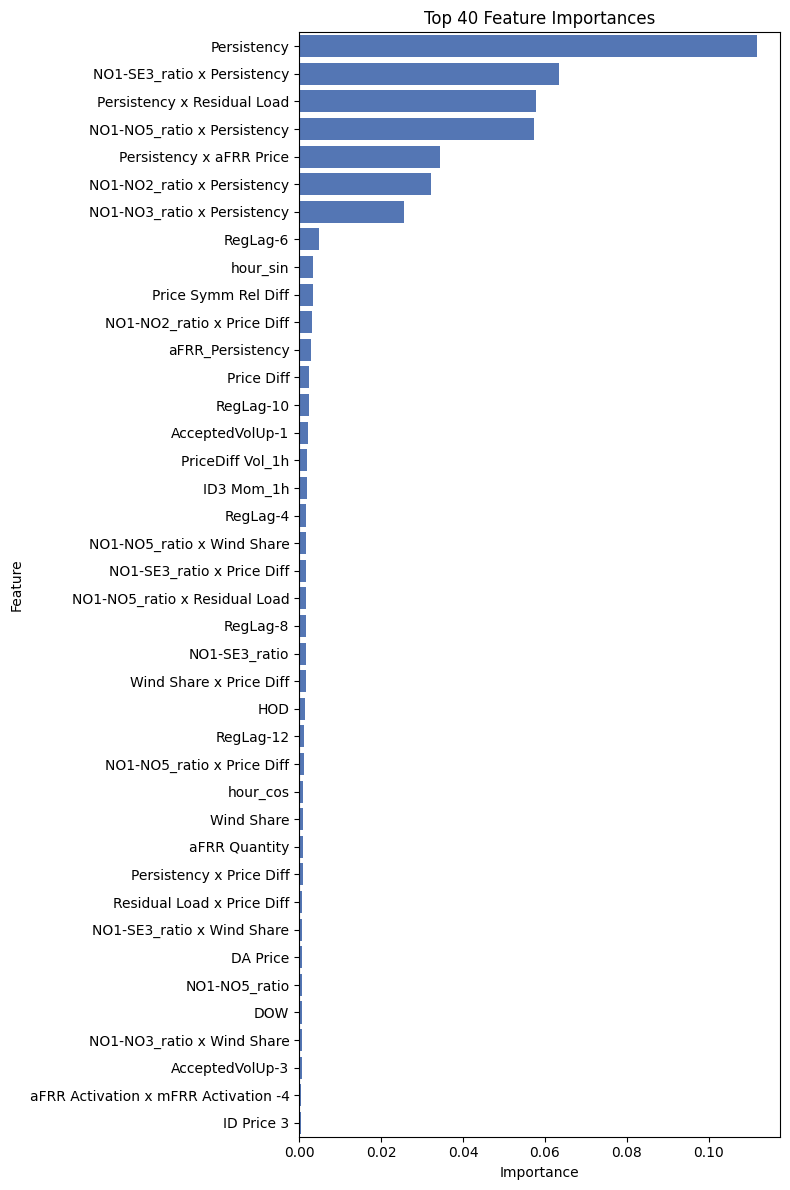

In [3]:
# 4. CatBoost-only + 4 HPO trials (NO1)
cat_hpo_cfg = base_common(area='NO1')
cat_hpo_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'cat_only_hpo4_no_bag'),
    time_limit=240,
    presets='best_quality',
    model_preset='cat_only',
    hpo_trials=4, hpo_searcher='random', hpo_scheduler='local',
))
# Uncomment to run
run_training('CatBoost-only HPO(4) NO1', **cat_hpo_cfg)

In [ ]:
# 5. Baseline RF/XT priority for NO2 (area switch)
no2_baseline_cfg = base_common(area='NO2')
no2_baseline_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'baseline_rf_xt_priority_NO2'),
    time_limit=120,
    presets='best_quality',
    model_preset='rf_xt_priority',
    hpo_trials=0, hpo_searcher='random', hpo_scheduler='local',
))
# Uncomment to run
# run_training('Baseline RF/XT Priority NO2', **no2_baseline_cfg)

In [ ]:
# 6. Stacking example (rf_xt_boost_stack) with modest time limit
stack_cfg = base_common(area='NO1')
stack_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'stack_rf_xt_boost'),
    time_limit=300,
    presets='best_quality',
    model_preset='rf_xt_boost_stack',
    num_bag_folds=0, num_stack_levels=0,  # keep disabled per requirement
    hpo_trials=0,
))
# Uncomment to run
# run_training('Stack Config (no actual bag/stack) NO1', **stack_cfg)

In [8]:
# 7. Batch runner: choose which configs to execute in sequence
batch = [
    # ('Baseline NO1', baseline_cfg),
    # ('CatBoost HPO4 NO1', cat_hpo_cfg),
    # ('Baseline NO2', no2_baseline_cfg),
]
results = {}
for name, cfg in batch:
    metrics = run_training(name, **cfg)
    results[name] = metrics
if results:
    print('Summary (macro F1):', {k: v.get('val_f1_macro') for k, v in results.items()})

### Notes
- Increase `time_limit` substantially (e.g., 1800+) for higher quality models.
- Set class weighting (e.g., `weight_factor_up=1.3`) to emphasize minority classes.
- Enable categorical RegLag features via `use_categorical_reglag=True` if desired.
- For persistence across re-runs, choose distinct `output_dir` names.

In [ ]:
# XGBoost-only (no HPO) sanity run
xgb_cfg = base_common(area='NO1')
xgb_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'xgb_only_baseline_light'),
    time_limit=180,
    presets='medium_quality',
    model_preset='xgb_only',
    hpo_trials=0,               # disable HPO to isolate training
    hpo_searcher='random',
    hpo_scheduler='local',
    #data_start='2025-06-01',    # keep subset for speed
))
run_training('XGBoost-only BASELINE NO1 LIGHT', **xgb_cfg)


=== Run: XGBoost-only FULL FIXED VARIANTS NO1 ===
Flow index range: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
Flow index range: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
[add_interactions] Dropping duplicate columns to avoid reindex errors: ['NO1-NO2_ratio', 'NO1-NO3_ratio', 'NO1-NO5_ratio', 'NO1-SE3_ratio']
Consumption shape: (65568, 1)
Production shape: (65568, 8)
Day-ahead prices shape: (65760, 2)
Intraday hourly stats shape: (65565, 13)
Number of NaNs before dropna: 15743
Normalized nullable integer dtypes to int64 for: ['DA Scarcity', 'aFRR_ActDirNum-4', 'aFRR_ActDirNum-6', 'aFRR_ActDirNum-8', 'aFRR Activation x mFRR Activation -4', 'aFRR Activation x mFRR Activation -6']
Final preprocessed DataFrame shape: (63345, 85)
                     NO1-NO2_ratio  NO1-NO3_ratio  NO1-NO5_ratio  \
Time                                                               
2025-11-08 20:45

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.45 GB / 13.85 GB (17.7%)
Disk Space Avail:   364.29 GB / 952.62 GB (38.2%)
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.45 GB / 13.85 GB (17.7%)
Disk Space Avail:   364.29 GB / 952.62 GB (38.2%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True)

Dataset splits: train=38007, val=12669, test=12669 (total=63345)


Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\xgb_only_full_fixed"
Train Data Rows:    38007
Train Data Columns: 84
Tuning Data Rows:    12669
Tuning Data Columns: 84
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\xgb_only_full_fixed"
Train Data Rows:    38007
Train Data Columns: 84
Tuning Data Rows:    12669
Tuning Data Columns: 84
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2483.81 MB
	Train Data (Original)  Memory Usage: 29.10 MB (1.2% of available memory)
Fitting AutoMLPipelineFeatureGenera

Tuning up-multiplier alpha=0.75: F1(up)=0.3021, F1(macro)=0.5857
Tuning up-multiplier alpha=0.90: F1(up)=0.4040, F1(macro)=0.6190
Tuning up-multiplier alpha=1.00: F1(up)=0.4390, F1(macro)=0.6307
Tuning up-multiplier alpha=1.10: F1(up)=0.4297, F1(macro)=0.6264
Tuning up-multiplier alpha=1.18: F1(up)=0.4329, F1(macro)=0.6274
Tuning up-multiplier alpha=1.25: F1(up)=0.4342, F1(macro)=0.6279
Tuning up-multiplier alpha=1.30: F1(up)=0.4322, F1(macro)=0.6272
Tuning up-multiplier alpha=1.38: F1(up)=0.4306, F1(macro)=0.6266
Tuning up-multiplier alpha=1.45: F1(up)=0.4293, F1(macro)=0.6261
Tuning up-multiplier alpha=1.50: F1(up)=0.4293, F1(macro)=0.6261
Tuning up-multiplier alpha=1.25: F1(up)=0.4342, F1(macro)=0.6279
Tuning up-multiplier alpha=1.30: F1(up)=0.4322, F1(macro)=0.6272
Tuning up-multiplier alpha=1.38: F1(up)=0.4306, F1(macro)=0.6266
Tuning up-multiplier alpha=1.45: F1(up)=0.4293, F1(macro)=0.6261
Tuning up-multiplier alpha=1.50: F1(up)=0.4293, F1(macro)=0.6261
Tuning up-multiplier alph

These features in provided data are not utilized by the predictor and will be ignored: ['ID Price 3 - Day Ahead Price']
Computing feature importance via permutation shuffling for 83 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
Computing feature importance via permutation shuffling for 83 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
	209.73s	= Expected runtime (20.97s per shuffle set)
	209.73s	= Expected runtime (20.97s per shuffle set)
	54.74s	= Actual runtime (Completed 8 of 10 shuffle sets) (Early stopping due to lack of time...)
	54.74s	= Actual runtime (Completed 8 of 10 shuffle sets) (Early stopping due to lack of time...)


Top feature importances:
  NO1-SE3_ratio x Persistency: 0.061047
  NO1-NO5_ratio x Persistency: 0.060325
  Persistency x aFRR Price: 0.059059
  NO1-NO3_ratio x Persistency: 0.042769
  Persistency: 0.039088
  NO1-NO2_ratio x Persistency: 0.018597
  Persistency x Residual Load: 0.013853
  hour_cos: 0.003818
  DA Price: 0.003791
  HOD: 0.003011
  aFRR_Persistency: 0.002908
  hour_sin: 0.002599
  aFRR_ActCat-8: 0.002470
  NO1-NO2_ratio: 0.002439
  NO1-SE3_ratio: 0.002302
  Persistency x Import/Consumption: 0.002188
  Persistency x Peak: 0.002078
  aFRR Price: 0.001869
  NO1-NO5_ratio: 0.001757
  RegLag-12: 0.001678
  Wind Share: 0.001386
  RegLag-6: 0.001364
  aFRR_ActCat-6: 0.001362
  RegLagCat-6: 0.001354
  NO1-NO3_ratio x Price Diff: 0.001258
  Working Day: 0.001230
  Price Diff: 0.001211
  RegLag-8: 0.001204
  RegLagCat-8: 0.001172
  NO1-NO3_ratio x Wind Share: 0.001114
  Wind Production: 0.001099
  ID Price 3: 0.001077
  NO1-SE3_ratio x Residual Load: 0.000998
  NO1-SE3_ratio x Price 

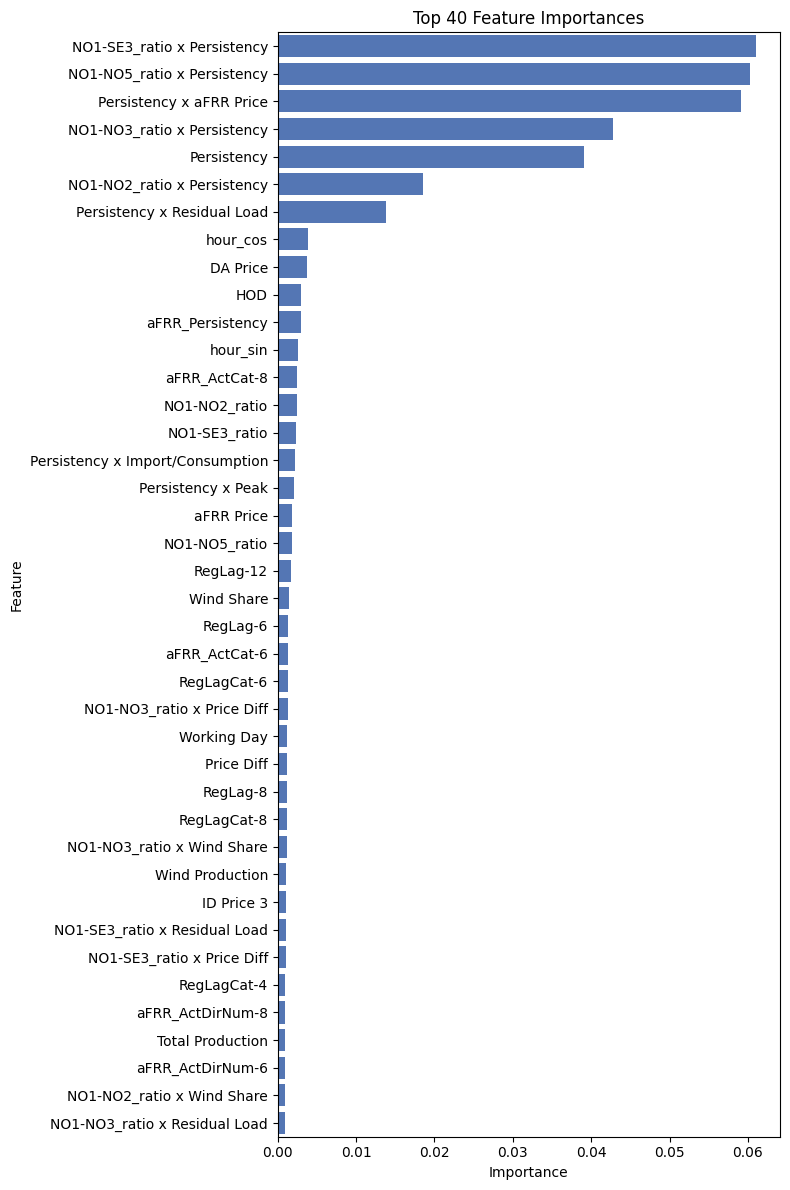

In [ ]:
# 8. XGBoost-only FULL run (fixed variants, full data)
xgb_full_cfg = base_common(area='NO1')
xgb_full_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'xgb_only_full_fixed_actual'),
    time_limit=1800,             # 30 minutes budget; adjust as needed
    presets='best_quality',
    model_preset='xgb_only_fixed',
    hpo_trials=0,                # no HPO; use fixed variants
    hpo_searcher='random',
    hpo_scheduler='local',
    data_start=None,             # ensure full dataset
))
run_training('XGBoost-only FULL FIXED VARIANTS NO1', **xgb_full_cfg)


In [9]:
# 10. Inspect trained model families from saved predictors
from autogluon.tabular import TabularPredictor
paths = [
    MODELS_DIR / 'xgb_only_full_fixed',
    MODELS_DIR / 'xgb_only_full_fixed_actual',
    MODELS_DIR / 'xgb_only_full_hpo6',
    MODELS_DIR / 'xgb_only_full_hpo2_quick',
]
for p in paths:
    p = str(p)
    if Path(p).exists():
        try:
            pred = TabularPredictor.load(p)
            print(f'Path: {p}')
            print('Models:', pred.model_names())
        except Exception as e:
            print(f'Failed to load {p}:', e)


Path: c:\PythonProjects\rl_reserve_markets\upreg_classify\models\xgb_only_full_fixed
Models: ['NeuralNetFastAI', 'LightGBMXT', 'LightGBM', 'RandomForestGini', 'RandomForestEntr', 'CatBoost', 'ExtraTreesGini', 'ExtraTreesEntr', 'XGBoost', 'NeuralNetTorch', 'LightGBMLarge', 'CatBoost_r177', 'NeuralNetTorch_r79', 'LightGBM_r131', 'NeuralNetFastAI_r191', 'CatBoost_r9', 'LightGBM_r96', 'NeuralNetTorch_r22', 'XGBoost_r33', 'ExtraTrees_r42', 'CatBoost_r137', 'NeuralNetFastAI_r102', 'CatBoost_r13', 'RandomForest_r195', 'LightGBM_r188', 'NeuralNetFastAI_r145', 'XGBoost_r89', 'NeuralNetTorch_r30', 'LightGBM_r130', 'NeuralNetTorch_r86', 'CatBoost_r50', 'NeuralNetFastAI_r11', 'ExtraTrees_r172', 'CatBoost_r69', 'NeuralNetFastAI_r103', 'NeuralNetTorch_r14', 'LightGBM_r161', 'NeuralNetFastAI_r143', 'CatBoost_r70', 'NeuralNetFastAI_r156', 'LightGBM_r196', 'RandomForest_r39', 'CatBoost_r167', 'NeuralNetFastAI_r95', 'NeuralNetTorch_r41', 'LightGBM_r15', 'NeuralNetTorch_r158', 'CatBoost_r86', 'NeuralNetF

In [23]:
# 11. Force-reload training modules to pick up latest hyperparameter presets
import importlib
import src.train.hyperparameters as hp
import src.train.train as tr
hp = importlib.reload(hp)
tr = importlib.reload(tr)
from src.train.hyperparameters import build_hyperparameters
print('xgb_only_fixed keys:', list(build_hyperparameters('xgb_only_fixed', hpo_trials=0).keys()))


xgb_only_fixed keys: ['XGB']


In [6]:
# 12. Sanity: XGBoost-only FIXED on subset, verify model families
xgb_subset_cfg = base_common(area='NO1')
xgb_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'xgb_only_fixed_subset_check'),
    time_limit=1000,
    presets='best_quality',
    model_preset='xgb_only_fixed',
    hpo_trials=5,
    data_start='2025-03-04',
))
metrics = run_training('XGB FIXED SUBSET CHECK', **xgb_subset_cfg)
# Show trained models
pred = TabularPredictor.load(xgb_subset_cfg['output_dir'])
print('Models:', pred.model_names())


=== Run: XGB FIXED SUBSET CHECK ===
Flow index range: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
Consumption shape: (65568, 1)
Production shape: (65568, 8)
Day-ahead prices shape: (65760, 2)
Intraday hourly stats shape: (65565, 13)
Number of NaNs before dropna: 13471


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [ ]:
# 13. Sanity: CatBoost-only on subset, mirror cfg of #12
from src.train.train import train_and_evaluate
reload_all()
cat_subset_cfg = base_common(area='NO1')
cat_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'cat_only_subset_check'),
    time_limit=600,
    presets='best_quality',
    model_preset='cat_only',
    hpo_trials=2,
    data_start='2025-03-04',
))
metrics = run_training('CAT ONLY SUBSET CHECK', **cat_subset_cfg)
# Show trained models
pred = TabularPredictor.load(cat_subset_cfg['output_dir'])
print('Models:', pred.model_names())


--- Reloading project modules ---
Reloaded: preprocess, features, hyperparameters, train
=== Run: CAT ONLY SUBSET CHECK ===
Flow index range: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
Flow index range: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
Consumption shape: (65568, 1)
Production shape: (65568, 8)
Day-ahead prices shape: (65760, 2)
Intraday hourly stats shape: (65565, 13)
Number of NaNs before dropna: 13471
Final preprocessed DataFrame shape: (63345, 65)
Dataset splits: train=38007, val=12669, test=12669 (total=63345)
Applied dataset start filter: from 2025-03-04 -> rows: 23985 (train 14391, val 4797, test 4797)
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
Consumption shape: (65568, 1)
Production shape: (65568, 8)
Day-ahead prices shape: (65760, 2)
Intraday hourly stats shape: (65565, 13)
Number of NaNs before dropna: 13471
Final

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       1.99 GB / 13.85 GB (14.4%)
Disk Space Avail:   402.85 GB / 952.62 GB (42.3%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       1.99 GB / 13.85 GB (14.4%)
Disk Space Avail:   402.85 GB / 952.62 GB (42.3%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 600s
AutoGluon

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
# 14. Sanity: LightGBM-only on subset, mirror cfg of #12
lgbm_subset_cfg = base_common(area='NO1')
lgbm_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'lgbm_only_subset_check'),
    time_limit=1000,
    presets='best_quality',
    model_preset='lgbm_only',
    hpo_trials=0,
    data_start='2025-03-04',
))
metrics = run_training('LGBM ONLY SUBSET CHECK', **lgbm_subset_cfg)
# Show trained models
pred = TabularPredictor.load(lgbm_subset_cfg['output_dir'])
print('Models:', pred.model_names())


=== Run: LGBM ONLY SUBSET CHECK ===
Flow index range: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
Consumption shape: (65568, 1)
Production shape: (65568, 8)
Day-ahead prices shape: (65760, 2)
Intraday hourly stats shape: (65565, 13)
Number of NaNs before dropna: 13471


AttributeError: 'DataFrame' object has no attribute 'dtype'

=== Run: XGB FIXED SUBSET NO INTERACTIONS ===
Flow index range: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
[add_interactions] Dropping duplicate columns to avoid reindex errors: ['NO1-NO2_ratio', 'NO1-NO3_ratio', 'NO1-NO5_ratio', 'NO1-SE3_ratio']
Consumption shape: (65568, 1)
Production shape: (65568, 8)
Day-ahead prices shape: (65760, 2)
Intraday hourly stats shape: (65565, 13)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       3.90 GB / 13.85 GB (28.1%)
Disk Space Avail:   403.01 GB / 952.62 GB (42.3%)
Presets specified: ['medium_quality']


Number of NaNs before dropna: 15803
Normalized nullable integer dtypes to int64 for: ['DA Scarcity', 'aFRR_ActDirNum-4', 'aFRR_ActDirNum-6', 'aFRR_ActDirNum-8', 'aFRR Activation x mFRR Activation -4', 'aFRR Activation x mFRR Activation -6']
Final preprocessed DataFrame shape: (63341, 91)
                     NO1-NO2_ratio  NO1-NO3_ratio  NO1-NO5_ratio  \
Time                                                               
2025-11-08 20:45:00       0.535190       0.570551       0.463167   
2025-11-08 21:00:00       0.569671       0.610564       0.448474   

                     NO1-SE3_ratio  RegLag-4 RegLagCat-4  RegLag-6  \
Time                                                                 
2025-11-08 20:45:00       0.174695        -1        down        -1   
2025-11-08 21:00:00       0.207251        -1        down        -1   

                    RegLagCat-6  RegLag-8 RegLagCat-8  ...  \
Time                                                   ...   
2025-11-08 20:45:00        down  

Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\xgb_fixed_subset_no_interactions"
Train Data Rows:    14389
Train Data Columns: 80
Tuning Data Rows:    4796
Tuning Data Columns: 80
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3983.32 MB
	Train Data (Original)  Memory Usage: 10.43 MB (0.3% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		

Tuning up-multiplier alpha=0.75: F1(up)=0.0188, F1(macro)=0.4514
Tuning up-multiplier alpha=0.90: F1(up)=0.0801, F1(macro)=0.4708
Tuning up-multiplier alpha=1.00: F1(up)=0.1223, F1(macro)=0.4844
Tuning up-multiplier alpha=1.10: F1(up)=0.1469, F1(macro)=0.4921
Tuning up-multiplier alpha=1.18: F1(up)=0.2195, F1(macro)=0.5164
Tuning up-multiplier alpha=1.25: F1(up)=0.2516, F1(macro)=0.5265
Tuning up-multiplier alpha=1.30: F1(up)=0.2710, F1(macro)=0.5326
Tuning up-multiplier alpha=1.38: F1(up)=0.3016, F1(macro)=0.5424
Tuning up-multiplier alpha=1.45: F1(up)=0.3037, F1(macro)=0.5408
Tuning up-multiplier alpha=1.50: F1(up)=0.3029, F1(macro)=0.5388
Tuning up-multiplier alpha=1.75: F1(up)=0.3348, F1(macro)=0.5455
Tuning up-multiplier alpha=2.00: F1(up)=0.3298, F1(macro)=0.5388
Tuning up-multiplier alpha=2.50: F1(up)=0.2747, F1(macro)=0.4929
Tuning up-multiplier alpha=3.00: F1(up)=0.2310, F1(macro)=0.3785
Tuning up-multiplier alpha=3.50: F1(up)=0.2052, F1(macro)=0.2162
Tuning up-multiplier alph

These features in provided data are not utilized by the predictor and will be ignored: ['wind_error_t+4', 'wind_error_t+2', 'ID Price 3 - Day Ahead Price']
Computing feature importance via permutation shuffling for 77 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
	26.73s	= Expected runtime (2.67s per shuffle set)
	7.82s	= Actual runtime (Completed 10 of 10 shuffle sets)


Top feature importances:
  Persistency: 0.078893
  DA Price: 0.032952
  RegLagCat-4: 0.023499
  HOD: 0.011338
  NO1-NO2_ratio: 0.003908
  NO1-NO2_ratio x Wind Share: 0.002538
  ID Price 3: 0.001719
  Price Symm Rel Diff: 0.001427
  Cross Border Stress: 0.001380
  NO1-NO3_ratio: 0.001309
  DA/ID Price Ratio: 0.001281
  RegLagCat-6: 0.001174
  NO1-NO3_ratio x Wind Share: 0.001116
  aFRR Quantity: 0.001113
  Working Day: 0.001078
  NO1-NO2_ratio x Price Diff: 0.000539
  Price Diff: 0.000366
  hour_sin: 0.000271
  Total Imports: 0.000221
  Residual Load x Price Diff: 0.000181
  NO1-SE3_ratio x Residual Load: 0.000178
  NO1-NO5_ratio: 0.000177
  aFRR Activation x mFRR Activation -4: 0.000163
  Wind Share x Price Diff: 0.000147
  Consumption: 0.000122
  NO1-NO5_ratio x Price Diff: 0.000061
  AcceptedVolUp-2: 0.000004
  NO1-SE3_ratio: 0.000000
  RegLag-4: 0.000000
  RegLag-12: 0.000000
  RegLagCat-10: 0.000000
  RegLag-10: 0.000000
  RegLagCat-8: 0.000000
  RegLag-8: 0.000000
  RegLag-6: 0.00

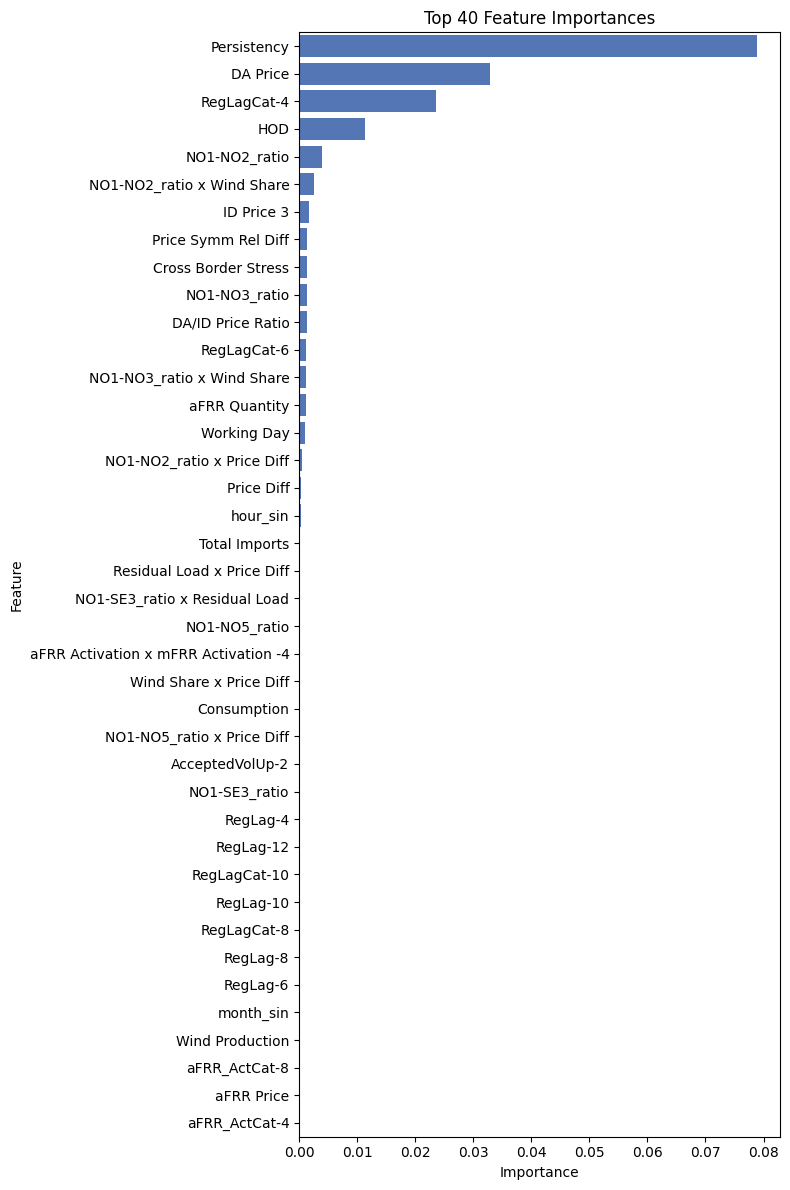

In [4]:
# 15. Subset run with persistency interactions disabled (XGB fixed)
xgb_no_inter_subset_cfg = base_common(area='NO1')
xgb_no_inter_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'xgb_fixed_subset_no_interactions'),
    time_limit=600,
    presets='medium_quality',
    model_preset='xgb_only_fixed',
    hpo_trials=0,
    data_start='2025-03-04',
    disable_persistency_interactions=True,
))
metrics = run_training('XGB FIXED SUBSET NO INTERACTIONS', **xgb_no_inter_subset_cfg)
# Show trained models
pred = TabularPredictor.load(xgb_no_inter_subset_cfg['output_dir'])
print('Models:', pred.model_names())


=== Run: LGBM ONLY HPO(4) SUBSET CHECK ===
Flow index range: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-11-13 23:45:00 (rows=65568)
[add_interactions] Dropping duplicate columns to avoid reindex errors: ['NO1-NO2_ratio', 'NO1-NO3_ratio', 'NO1-NO5_ratio', 'NO1-SE3_ratio']
Consumption shape: (65568, 1)
Production shape: (65568, 8)
Day-ahead prices shape: (65760, 2)
Intraday hourly stats shape: (65565, 13)
Number of NaNs before dropna: 15743


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.38 GB / 13.85 GB (17.2%)
Disk Space Avail:   360.45 GB / 952.62 GB (37.8%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1


Normalized nullable integer dtypes to int64 for: ['DA Scarcity', 'aFRR_ActDirNum-4', 'aFRR_ActDirNum-6', 'aFRR_ActDirNum-8', 'aFRR Activation x mFRR Activation -4', 'aFRR Activation x mFRR Activation -6']
Final preprocessed DataFrame shape: (63345, 85)
                     NO1-NO2_ratio  NO1-NO3_ratio  NO1-NO5_ratio  \
Time                                                               
2025-11-08 20:45:00       0.535190       0.570551       0.463167   
2025-11-08 21:00:00       0.569671       0.610564       0.448474   

                     NO1-SE3_ratio  RegLag-4 RegLagCat-4  RegLag-6  \
Time                                                                 
2025-11-08 20:45:00       0.174695        -1        down        -1   
2025-11-08 21:00:00       0.207251        -1        down        -1   

                    RegLagCat-6  RegLag-8 RegLagCat-8  ...  \
Time                                                   ...   
2025-11-08 20:45:00        down        -1        down  ...   
2025-11

Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\lgbm_only_subset_hpo"
Train Data Rows:    14391
Train Data Columns: 84
Tuning Data Rows:    4797
Tuning Data Columns: 84
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2420.56 MB
	Train Data (Original)  Memory Usage: 11.02 MB (0.5% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting Cate

  0%|          | 0/4 [00:00<?, ?it/s]

Fitted model: LightGBM\T1 ...
	0.4637	 = Validation score   (f1_macro)
	2.91s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: LightGBM\T2 ...
	0.439	 = Validation score   (f1_macro)
	3.51s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM\T3 ...
	0.4376	 = Validation score   (f1_macro)
	2.8s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM\T4 ...
	0.4455	 = Validation score   (f1_macro)
	2.85s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the 881.98s of remaining time.
	Ensemble Weights: {'LightGBM\T1': 1.0}
	0.4637	 = Validation score   (f1_macro)
	0.16s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 18.23s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 190287.8 rows/s (4797 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("c:\PythonProj

Tuning up-multiplier alpha=0.75: F1(up)=0.0077, F1(macro)=0.4487
Tuning up-multiplier alpha=0.90: F1(up)=0.0304, F1(macro)=0.4563
Tuning up-multiplier alpha=1.00: F1(up)=0.0524, F1(macro)=0.4637
Tuning up-multiplier alpha=1.10: F1(up)=0.0626, F1(macro)=0.4667
Tuning up-multiplier alpha=1.18: F1(up)=0.0789, F1(macro)=0.4713
Tuning up-multiplier alpha=1.25: F1(up)=0.1051, F1(macro)=0.4803
Tuning up-multiplier alpha=1.30: F1(up)=0.1076, F1(macro)=0.4812
Tuning up-multiplier alpha=1.38: F1(up)=0.1132, F1(macro)=0.4828
Tuning up-multiplier alpha=1.45: F1(up)=0.1307, F1(macro)=0.4884
Tuning up-multiplier alpha=1.50: F1(up)=0.1417, F1(macro)=0.4920
Tuning up-multiplier alpha=1.75: F1(up)=0.1946, F1(macro)=0.5084
Tuning up-multiplier alpha=2.00: F1(up)=0.2551, F1(macro)=0.5290
Tuning up-multiplier alpha=2.50: F1(up)=0.3203, F1(macro)=0.5504
Tuning up-multiplier alpha=3.00: F1(up)=0.3461, F1(macro)=0.5587
Tuning up-multiplier alpha=3.50: F1(up)=0.3542, F1(macro)=0.5609
Tuning up-multiplier alph

These features in provided data are not utilized by the predictor and will be ignored: ['wind_error_t+4', 'wind_error_t+2', 'ID Price 3 - Day Ahead Price']
Computing feature importance via permutation shuffling for 81 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
	20.29s	= Expected runtime (2.03s per shuffle set)
	7.43s	= Actual runtime (Completed 10 of 10 shuffle sets)


Top feature importances:
  DA Price: 0.030087
  NO1-NO5_ratio x Persistency: 0.027833
  Persistency x Residual Load: 0.020490
  NO1-NO2_ratio x Persistency: 0.012863
  NO1-SE3_ratio x Persistency: 0.012565
  Persistency: 0.011202
  RegLagCat-4: 0.008373
  aFRR Quantity: 0.008079
  HOD: 0.006140
  Persistency x aFRR Price: 0.004912
  NO1-NO3_ratio x Persistency: 0.004649
  ID Price 3: 0.004615
  Persistency x Price Diff: 0.004353
  Persistency x Import/Consumption: 0.003698
  NO1-SE3_ratio x Price Diff: 0.003592
  NO1-NO5_ratio: 0.003325
  hour_sin: 0.003244
  RegLagCat-6: 0.003189
  hour_cos: 0.003050
  Wind Share x Price Diff: 0.002973
  NO1-NO3_ratio: 0.002764
  RegLag-8: 0.002752
  Import/Consumption: 0.002454
  DA/ID Price Ratio: 0.002322
  NO1-NO3_ratio x Wind Share: 0.002172
  NO1-NO2_ratio: 0.002069
  DOW: 0.002052
  Wind Production: 0.001770
  Cross Border Stress: 0.001415
  aFRR_Persistency: 0.001395
  RegLag-4: 0.001330
  NO1-NO2_ratio x Residual Load: 0.001290
  Residual Loa

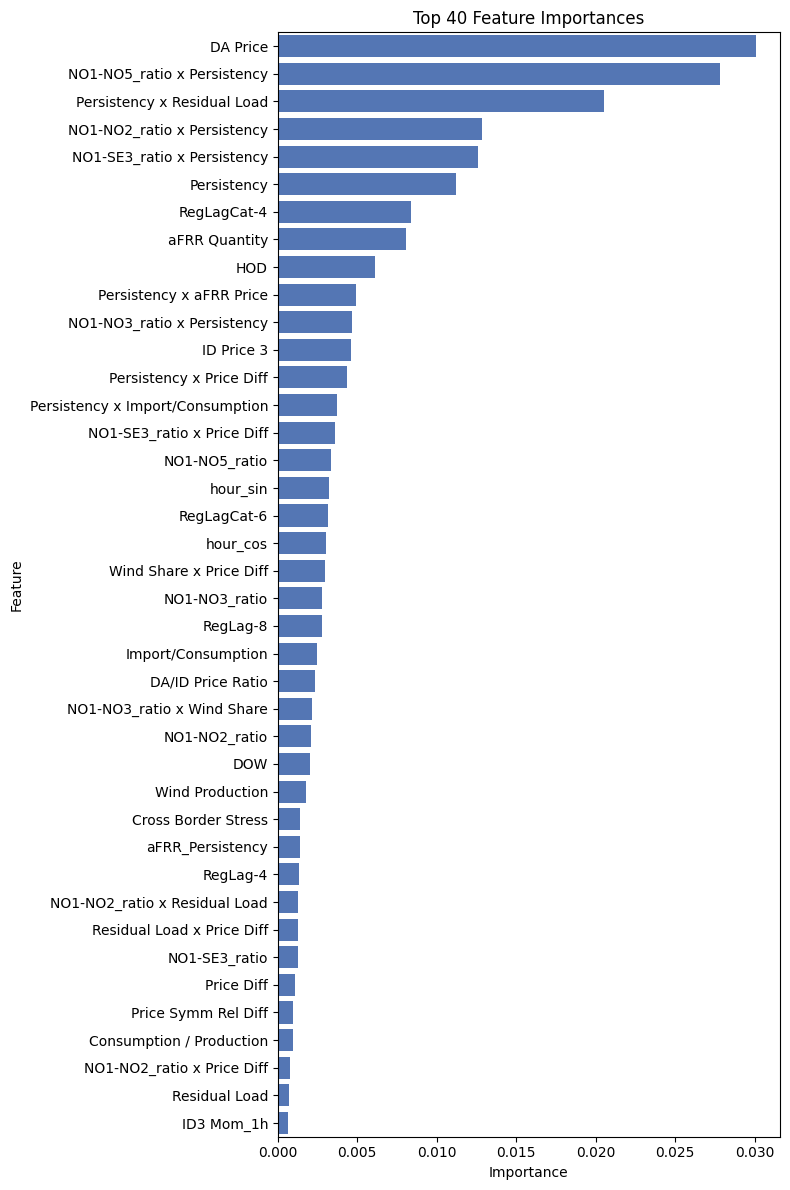

In [4]:
# 16. LightGBM-only HPO on subset (verify only GBM models)
lgbm_hpo_subset_cfg = base_common(area='NO1')
lgbm_hpo_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'lgbm_only_subset_hpo'),
    time_limit=900,
    presets='best_quality',
    model_preset='lgbm_only',
    hpo_trials=4,
    hpo_searcher='random',
    hpo_scheduler='local',
    data_start='2025-03-04',
))
metrics = run_training('LGBM ONLY HPO(4) SUBSET CHECK', **lgbm_hpo_subset_cfg)
# Show trained models
pred = TabularPredictor.load(lgbm_hpo_subset_cfg['output_dir'])
print('Models:', pred.model_names())

In [6]:
# 17. Inspect features after persistency-interactions disabled run
# Load predictor from cell #15 output_dir and list any Persistency interaction features
from autogluon.tabular import TabularPredictor
p = TabularPredictor.load(xgb_no_inter_subset_cfg['output_dir'])
feat_names = []
try:
    feat_names = list(p.feature_metadata.get_features())
except Exception:
    try:
        feat_names = list(p._learner.feature_metadata_in.get_features())
    except Exception:
        try:
            feat_names = list(p._learner.features)
        except Exception:
            feat_names = []
print('Total features:', len(feat_names))
bad = [f for f in feat_names if (' x Persistency' in f) or ('Persistency x ' in f) or (' x PersistencyDown' in f) or ('PersistencyDown x ' in f)]
print('Persistency-interaction features found:', bad)

Total features: 71
Persistency-interaction features found: []
